In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFG_Matematicas


In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
#import visualkeras
from utils.utils import *


In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.TPUStrategy(tpu)

BaseException: ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!

In [4]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [5]:
data_indexes = [(i+1,j+1) for i in range(5) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [6]:
X_train = np.array(load_data_multithreaded(train_idxs,50, small = True))
print('train loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs,50, small = True))
print('validation loaded')
X_test = np.array(load_data_multithreaded(test_idxs,50, small = True))
print('test loaded')

train loaded
validation loaded
test loaded


In [ ]:
mean = np.mean(X_train.flatten())
std = np.std(X_train.flatten())

In [ ]:
mean, std

(0.002895285692411213, 0.01585630079850642)

In [ ]:
# X_train_norm = (X_train-mean)/std
# X_validation_norm = (X_validation-mean)/std
# X_test_norm = (X_test-mean)/std

# Preparing metrics and logger

In [29]:
from tensorflow.keras import backend as K

class MultiOutputEvaluation(tf.keras.metrics.Metric):

    def __init__(self, name='multi_output_eval', **kwargs):
        super(MultiOutputEvaluation, self).__init__(name=name, **kwargs)
        self.num_outputs = 7  # Adjust this to the actual number of outputs
        self.rmse_accumulators = [tf.keras.metrics.RootMeanSquaredError() for _ in range(self.num_outputs)]
        self.mae_accumulators = [tf.keras.metrics.MeanAbsoluteError() for _ in range(self.num_outputs)]
        self.r2_accumulators = [tf.keras.metrics.R2Score() for _ in range(self.num_outputs)]

    def update_state(self, y_true, y_pred):
        for i in range(self.num_outputs):
            y_true_i = y_true[:, i]  # Extract i-th output from true values
            y_pred_i = y_pred[:, i]  # Extract i-th output from predicted values

            # Calculate RMSE, MAE, and R-squared for each output
            self.rmse_accumulators[i].update_state(y_true_i, y_pred_i)
            self.mae_accumulators[i].update_state(y_true_i, y_pred_i)
            self.r2_accumulators[i].update_state(y_true_i, y_pred_i)

    def result(self):
        rmse_values = [acc.result() for acc in self.rmse_accumulators]
        mae_values = [acc.result() for acc in self.mae_accumulators]
        r2_values = [acc.result() for acc in self.r2_accumulators]
        return [rmse_values, mae_values, r2_values]

In [30]:
multi_eval = MultiOutputEvaluation()

In [34]:
METRICS=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.R2Score(name='r2score'),
         multi_eval]

In [9]:
!pip install wandb

In [10]:
import wandb

In [11]:
#!wandb login --relogin "7d5df642c8f2f25efa71e1d04a8de4f7867f0149"

In [12]:
wandb.login()

from wandb.keras import WandbMetricsLogger
#from wandb.keras import WandbModelCheckpoint

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# MLP model

In [ ]:
#configure environment variables to get runs


wandb.init(
    # set the wandb project where this run will be logged
    project="anomaly_detection",
    name = "mlp-1",
    # track hyperparameters and run metadata
    config={
    "n_dense_layers": 5,
    "dense_activation_1": "relu",
    "dense_activation_2": "relu",
    "dense_activation_3": "relu",
    "dense_activation_4": "relu",
    "dense_activation_5": "relu",
    "architecture": "MLP",
    "dataset": "dataset_1_small",
    "early_stopping": True,
    "epochs": 1,
    }
)

config = wandb.config

In [35]:
#with tpu_strategy.scope(): , WandbMetricsLogger(log_freq=5)
  # Feedforward model
feedforward = tf.keras.Sequential([
    Input(shape=(440, 17)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

feedforward.compile(optimizer='adam', loss='mse', metrics=[METRICS])
#feedforward.summary()

In [36]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=1, verbose = 1,
                          callbacks=[early_stopping])


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__update_state() got an unexpected keyword argument 'sample_weight'


In [ ]:
feedforward.evaluate(X_test, y_test)
wandb.finish()

45/45 [==============================] - 1s 21ms/step - loss: 1.1381


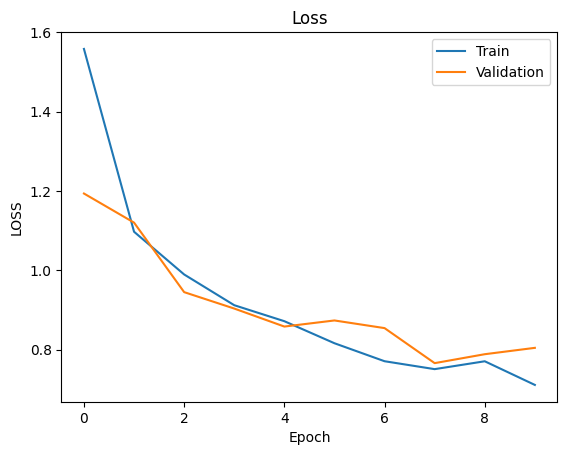

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(feedforward, X_test, y_test)

45/45 [==============================] - 0s 4ms/step - loss: 0.6624 - mae: 0.4776 - mse: 0.6624
Test mae: 0.4775702655315399
Test mse: 0.6623666882514954
1/1 [==============================] - 0s 82ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 3.027	4.346	1.127	0.023	0.439	0.547	4.861
prediction:	 1.010	3.915	0.902	0.120	0.204	1.622	3.693
------------
real:		 1.602	3.656	1.499	1.258	0.247	0.094	2.505
prediction:	 1.577	3.637	1.575	1.018	0.096	-0.013	2.462
------------
real:		 -0.122	2.202	0.987	0.386	-0.128	4.719	7.439
prediction:	 -0.194	2.275	1.162	0.333	0.135	4.380	4.434
------------
real:		 0.084	2.420	1.237	0.047	-0.064	4.162	3.578
prediction:	 0.377	2.452	1.029	0.199	0.126	3.099	2.951
------------
real:		 1.553	2.920	0.866	0.105	0.273	0.830	3.094
prediction:	 1.298	3.507	0.954	0.163	0.190	1.368	4.224


# Convolutional model

In [ ]:
cnn = tf.keras.Sequential([
# First Convolutional Block with padding
  Conv2D(32, (3, 3), activation='relu', input_shape=(440, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),

  # Second Convolutional Block with increased filters and padding
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),

  # Third Convolutional Block with increased filters, kernel size and padding
  Conv2D(128, (5, 5), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),


  # Flatten layer
  Flatten(),

  # Dense layers with Dropout for better regularization
  Dense(1024, activation='relu'),
  Dense(256, activation='relu'),
  Dense(64, activation='relu'),
  # Final output layer with 7 neurons
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 440, 17, 32)       320       
                                                                 
 batch_normalization_3 (Bat  (None, 440, 17, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 220, 8, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 8, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 220, 8, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 33s 235ms/step - loss: 8.1999 - mae: 1.1220 - mse: 8.1999 - val_loss: 5.3616 - val_mae: 1.7069 - val_mse: 5.3616
Epoch 2/40
133/133 [==============================] - 31s 230ms/step - loss: 1.0234 - mae: 0.6892 - mse: 1.0234 - val_loss: 4.9324 - val_mae: 1.6756 - val_mse: 4.9324
Epoch 3/40
133/133 [==============================] - 31s 231ms/step - loss: 0.8940 - mae: 0.6226 - mse: 0.8940 - val_loss: 3.4215 - val_mae: 1.3026 - val_mse: 3.4215
Epoch 4/40
133/133 [==============================] - 31s 230ms/step - loss: 0.8412 - mae: 0.5851 - mse: 0.8412 - val_loss: 3.6788 - val_mae: 1.3852 - val_mse: 3.6788
Epoch 5/40
133/133 [==============================] - 31s 232ms/step - loss: 0.7785 - mae: 0.5535 - mse: 0.7785 - val_loss: 2.7687 - val_mae: 1.0985 - val_mse: 2.7687
Epoch 6/40
133/133 [==============================] - 31s 232ms/step - loss: 0.7240 - mae: 0.5390 - mse: 0.7240 - val_loss: 1.1709 - val_mae: 0.7927 - val_mse: 1.170

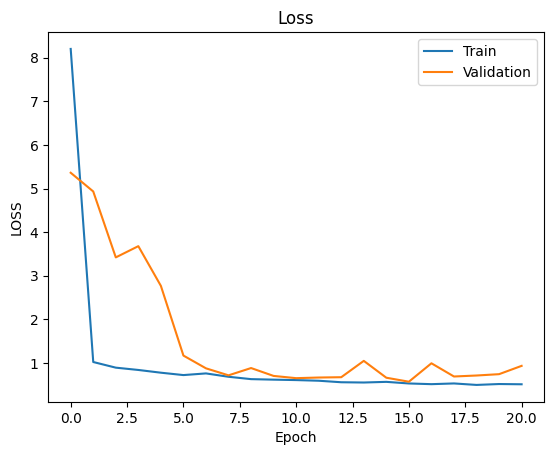

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(cnn, X_test, y_test,)

45/45 [==============================] - 2s 43ms/step - loss: 0.5614 - mae: 0.4556 - mse: 0.5614
Test mae: 0.4555557370185852
Test mse: 0.5613623857498169
1/1 [==============================] - 0s 129ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.666	4.713	1.343	1.126	0.475	1.336	6.544
prediction:	 2.091	5.161	1.555	1.050	0.140	1.206	6.333
------------
real:		 0.438	5.417	0.643	0.265	0.181	3.047	7.502
prediction:	 0.204	5.217	0.963	0.323	0.199	3.239	3.482
------------
real:		 0.644	3.594	2.021	0.654	0.450	4.522	3.774
prediction:	 1.058	3.793	2.109	0.922	0.403	3.430	3.813
------------
real:		 -0.114	4.270	0.995	0.403	0.237	1.449	5.253
prediction:	 0.129	4.607	1.204	0.235	0.126	1.591	5.528
------------
real:		 0.394	2.981	1.678	0.811	-0.408	1.934	7.187
prediction:	 0.637	2.891	1.704	0.968	-0.371	1.347	5.071


# Recurrent Neural Network with simple RNN layer

In [ ]:
rnn = tf.keras.Sequential([
    SimpleRNN(512, input_shape=(440, 17), return_sequences=True),
    SimpleRNN(256),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 440, 512)          271360    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               196864    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 7)                 455       
                                                                 
Total params: 509831 (1.94 MB)
Trainable params: 509831 (1.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 58s 423ms/step - loss: 1.6833 - mae: 0.8991 - mse: 1.6833 - val_loss: 1.4679 - val_mae: 0.8309 - val_mse: 1.4679
Epoch 2/40
133/133 [==============================] - 55s 414ms/step - loss: 1.4663 - mae: 0.8422 - mse: 1.4663 - val_loss: 1.4559 - val_mae: 0.8288 - val_mse: 1.4559
Epoch 3/40
133/133 [==============================] - 55s 416ms/step - loss: 1.4670 - mae: 0.8413 - mse: 1.4670 - val_loss: 1.4979 - val_mae: 0.8411 - val_mse: 1.4979
Epoch 4/40
133/133 [==============================] - 56s 418ms/step - loss: 1.4661 - mae: 0.8412 - mse: 1.4661 - val_loss: 1.4837 - val_mae: 0.8366 - val_mse: 1.4837
Epoch 5/40
133/133 [==============================] - 57s 425ms/step - loss: 1.4605 - mae: 0.8384 - mse: 1.4605 - val_loss: 1.4908 - val_mae: 0.8434 - val_mse: 1.4908
Epoch 6/40
133/133 [==============================] - 55s 418ms/step - loss: 1.4519 - mae: 0.8368 - mse: 1.4519 - val_loss: 1.4520 - val_mae: 0.8292 - val_mse: 1.452

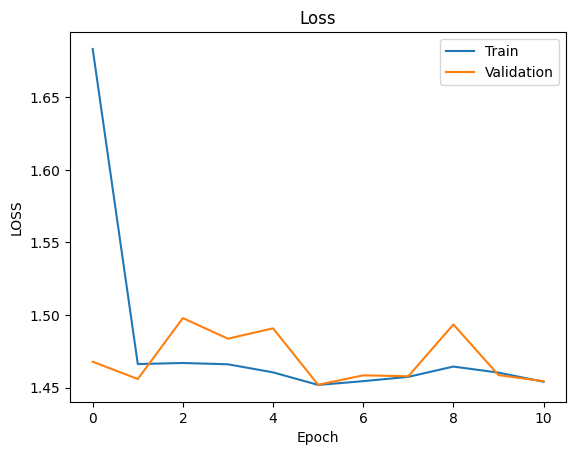

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn, X_test, y_test)

45/45 [==============================] - 7s 154ms/step - loss: 1.4301 - mae: 0.8244 - mse: 1.4301
Test mae: 0.82444167137146
Test mse: 1.4300614595413208
1/1 [==============================] - 0s 320ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.532	3.774	2.034	0.272	0.266	2.737	3.284
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 1.392	4.172	1.497	0.793	0.679	0.430	4.179
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 0.949	2.186	1.636	0.650	0.552	0.101	4.052
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 0.440	4.961	1.237	0.775	-0.585	1.431	0.658
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 -0.318	2.314	0.592	0.324	0.403	1.349	7.563
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166


#  Recurrent Neural Network Model with LSTM

In [ ]:
with tpu_strategy.scope():
  rnn_lstm = tf.keras.Sequential([
      LSTM(512, input_shape=(440, 17)),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(7)
  ])

  rnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
  rnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1085440   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 1,258,375
Trainable params: 1,258,375
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 20s 112ms/step - loss: 1.7189 - mae: 0.8987 - mse: 1.7189 - val_loss: 1.5249 - val_mae: 0.8558 - val_mse: 1.5249
Epoch 2/20
133/133 [==============================] - 11s 85ms/step - loss: 1.4710 - mae: 0.8415 - mse: 1.4710 - val_loss: 1.4508 - val_mae: 0.8336 - val_mse: 1.4508
Epoch 3/20
 51/133 [==========>...................] - ETA: 5s - loss: 1.4538 - mae: 0.8353 - mse: 1.4538

KeyboardInterrupt: 

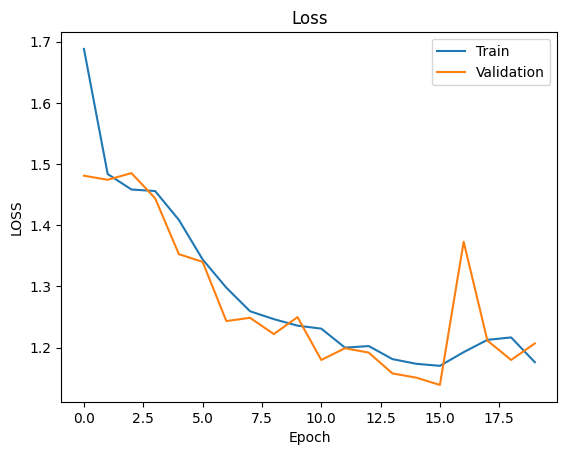

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn_lstm, X_test, y_test,)

45/45 [==============================] - 11s 249ms/step - loss: 1.1874 - mae: 0.7382 - mse: 1.1874
Test mae: 0.7382071614265442
Test mse: 1.187353253364563
1/1 [==============================] - 1s 608ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.201	4.595	1.103	0.657	0.376	6.127	1.491
prediction:	 0.388	3.669	1.431	0.444	0.162	4.016	2.405
------------
real:		 0.099	5.491	0.277	0.067	0.336	0.548	5.680
prediction:	 0.496	3.425	1.122	0.211	0.159	3.598	3.324
------------
real:		 1.644	3.717	0.567	0.449	0.306	4.616	3.897
prediction:	 0.438	3.586	1.285	0.329	0.166	3.874	2.835
------------
real:		 -1.029	4.504	1.135	0.137	0.669	4.045	3.370
prediction:	 0.474	3.411	1.015	0.081	0.168	3.125	4.312
------------
real:		 0.376	4.555	1.674	0.566	0.104	2.381	0.708
prediction:	 0.452	3.930	1.661	0.588	0.293	4.036	1.444
